# Set-up

In [ ]:
import aiohttp
import asyncio
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import re
import requests
from geopy.distance import geodesic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/CS3244 Group ID31/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv'
df = pd.read_csv(path)

In [ ]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


# Feature Engineering

## Compute Distance to Nearby MRT Stations

In order to compute the distance to closest nearby MRT stations, we need to first have Geo-spatial information about each flat sold. More specifically, we need the latitude and longitude information of each flat sold.

We first extract all the unique building information of the sold flats. In this case we have 9551 buildings where we need to query for their longitude and latitude.

In [ ]:
unique_buildings = df[['block', 'street_name']].drop_duplicates()
len(unique_buildings)

9551

In [ ]:
unique_buildings = unique_buildings.reset_index(drop = True)

We make a API call using OneMap API to extract the longitude and latitude of each building

In [ ]:
def onemap_api(data):
    async def fetch(session, block, street):
        search_val = f"{block} {street}"
        url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={search_val}&returnGeom=Y&getAddrDetails=Y&pageNum=1"

        async with session.get(url) as response:
            try:
                result = await response.json()
                result = result['results'][0]  # Retrieve top result
                # Getting Latitude and Longitude
                latitude = result['LATITUDE']
                longitude = result['LONGITUDE']
                return latitude, longitude
            except aiohttp.ClientResponseError:
                return None, None
            except (KeyError, IndexError) as e:
                print(f"Error processing response: {e}")
                return None, None

    async def main():
        tasks = []
        async with aiohttp.ClientSession() as session:
            for index, row in data.iterrows():
                task = asyncio.create_task(fetch(session, row['block'], row['street_name']))
                tasks.append(task)
            results = await asyncio.gather(*tasks)
        return results

    return asyncio.run(main())

Running this cell will begin the API Calls to find the longitude and latitude of each unique building. This cell may not always work fully as there could be an influx of API calls by other users on the onemap api interface. For simplicity, we successfully ran the API call once before and saved the building information into a separate csv file for repeated use.

In [ ]:
#building_info = onemap_api(unique_buildings)

#building_info = pd.DataFrame(building_info)
#unique_buildings['latitude'] = building_info[0]
#unique_buildings['longitude'] = building_info[1]

#unique_buildings.to_csv('building_info') # save a copy for reference in the future

Mrt and LRT Stations Dataset: https://www.kaggle.com/datasets/yxlee245/singapore-train-station-coordinates/data

Using the MRT and LRT Stations dataset that we found from Kaggle, which happens to come with the geospatial features (longitude and latitude) of each MRT station in Singapore, we will begin finding the closest mrt station for each building and its corresponding distance to that station.

In [ ]:
building_info_path = '/content/drive/MyDrive/CS3244 Group ID31/building_info.csv'
mrt_lrt_data_path = '/content/drive/MyDrive/CS3244 Group ID31/mrt_lrt_data.csv'

unique_buildings = pd.read_csv(building_info_path, index_col=0)
mrt_lrt_data = pd.read_csv(mrt_lrt_data_path)

In [ ]:
unique_buildings.head()

,block,street_name,latitude,longitude
0,406,ANG MO KIO AVE 10,1.362005,103.853880
1,108,ANG MO KIO AVE 4,1.370966,103.838202
2,602,ANG MO KIO AVE 5,1.380709,103.835368
3,465,ANG MO KIO AVE 10,1.366201,103.857201
4,601,ANG MO KIO AVE 5,1.381041,103.835132


In [ ]:
mrt_lrt_data.head()

,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [ ]:
def compute_distance(building_row, mrt_lrt_data):
    address_lat, address_lng = building_row[['latitude','longitude']]
    min_distance = 9999.0
    for idx, (stn_lat, stn_lng) in enumerate(zip(mrt_lrt_data['lat'], mrt_lrt_data['lng'])):
        distance = geodesic((address_lat, address_lng), (stn_lat, stn_lng)).km
        # Finding shortest distance to closest mrt
        if distance < min_distance:
            min_distance = distance
            closest_mrt = mrt_lrt_data['station_name'][idx]
    return min_distance, closest_mrt

In [ ]:
closest_mrt_and_distance = unique_buildings.apply(compute_distance, mrt_lrt_data=mrt_lrt_data, axis=1)

In [ ]:
closest_mrt_and_distance_df = closest_mrt_and_distance.apply(pd.Series)
closest_mrt_and_distance_df

,0,1
0,1.007304,Ang Mo Kio
1,1.271398,Ang Mo Kio
2,1.069720,Yio Chu Kang
3,0.946884,Ang Mo Kio
4,1.092577,Yio Chu Kang
...,...,...
9546,0.541057,Toa Payoh
9547,1.306723,Bukit Gombak
9548,0.210770,Boon Keng
9549,0.960189,Tampines


In [ ]:
closest_mrt_and_distance_df.columns = ['shortest_distance_to_closest_mrt (km)', 'closest_mrt']
closest_mrt_and_distance_df

,shortest_distance_to_closest_mrt (km),closest_mrt
0,1.007304,Ang Mo Kio
1,1.271398,Ang Mo Kio
2,1.069720,Yio Chu Kang
3,0.946884,Ang Mo Kio
4,1.092577,Yio Chu Kang
...,...,...
9546,0.541057,Toa Payoh
9547,1.306723,Bukit Gombak
9548,0.210770,Boon Keng
9549,0.960189,Tampines


In [ ]:
# Append to Building Information
unique_buildings_information = pd.concat([unique_buildings, closest_mrt_and_distance_df], axis = 1)
unique_buildings_information

,block,street_name,latitude,longitude,shortest_distance_to_closest_mrt (km),closest_mrt
0,406,ANG MO KIO AVE 10,1.362005,103.853880,1.007304,Ang Mo Kio
1,108,ANG MO KIO AVE 4,1.370966,103.838202,1.271398,Ang Mo Kio
2,602,ANG MO KIO AVE 5,1.380709,103.835368,1.069720,Yio Chu Kang
3,465,ANG MO KIO AVE 10,1.366201,103.857201,0.946884,Ang Mo Kio
4,601,ANG MO KIO AVE 5,1.381041,103.835132,1.092577,Yio Chu Kang
...,...,...,...,...,...,...
9546,72,LOR 5 TOA PAYOH,1.333877,103.852073,0.541057,Toa Payoh
9547,439A,BT BATOK WEST AVE 8,1.356822,103.740331,1.306723,Bukit Gombak
9548,26B,ST. GEORGE'S LANE,1.321669,103.862718,0.210770,Boon Keng
9549,601B,TAMPINES AVE 9,1.360883,103.937511,0.960189,Tampines


## Computing Distance to Nearest Schools

General School Information Dataset: https://beta.data.gov.sg/collections/457/datasets/d_688b934f82c1059ed0a6993d2a829089/view

In this section, we will be extracting the features of the closest schools to the transacted resale flat. Parents in Singapore takes into consideration the potential schools nearby flats, which would shape the first 10+ years of education. Our hypothesis is that flats closer to schools with a higher status (SAP schools or IP schools or Gifted schools) would have higher resale prices.

In [ ]:
schools_path = '/content/drive/MyDrive/CS3244 Group ID31/schools.csv'

schools = pd.read_csv(schools_path)

In [ ]:
schools.head()

,school_name,url_address,address,postal_code,telephone_no,telephone_no_2,fax_no,fax_no_2,email_address,mrt_desc,...,nature_code,session_code,mainlevel_code,sap_ind,autonomous_ind,gifted_ind,ip_ind,mothertongue1_code,mothertongue2_code,mothertongue3_code
0,ADMIRALTY PRIMARY SCHOOL,https://admiraltypri.moe.edu.sg/,11 WOODLANDS CIRCLE,738907,63620598,na,63627512,na,ADMIRALTY_PS@MOE.EDU.SG,Admiralty Station,...,CO-ED SCHOOL,FULL DAY,PRIMARY,No,No,No,No,Chinese,Malay,Tamil
1,ADMIRALTY SECONDARY SCHOOL,http://www.admiraltysec.moe.edu.sg,31 WOODLANDS CRESCENT,737916,63651733,63654596,63652774,na,Admiralty_SS@moe.edu.sg,ADMIRALTY MRT,...,CO-ED SCHOOL,SINGLE SESSION,SECONDARY,No,No,No,No,Chinese,Malay,Tamil
2,AHMAD IBRAHIM PRIMARY SCHOOL,http://www.ahmadibrahimpri.moe.edu.sg,10 YISHUN STREET 11,768643,67592906,na,67592927,na,aips@moe.edu.sg,Yishun,...,CO-ED SCHOOL,SINGLE SESSION,PRIMARY,No,No,No,No,Chinese,Malay,Tamil
3,AHMAD IBRAHIM SECONDARY SCHOOL,http://www.ahmadibrahimsec.moe.edu.sg,751 YISHUN AVENUE 7,768928,67585384,na,67557778,na,aiss@moe.edu.sg,"CANBERRA MRT, YISHUN MRT",...,CO-ED SCHOOL,SINGLE SESSION,SECONDARY,No,No,No,No,Chinese,Malay,Tamil
4,AI TONG SCHOOL,http://www.aitong.moe.edu.sg,100 Bright Hill Drive,579646,64547672,na,64532726,na,AITONG_SCH@MOE.EDU.SG,Bishan MRT,...,CO-ED SCHOOL,SINGLE SESSION,PRIMARY,Yes,No,No,No,Chinese,na,na


In [ ]:
schools.columns

Index(['school_name', 'url_address', 'address', 'postal_code', 'telephone_no',
       'telephone_no_2', 'fax_no', 'fax_no_2', 'email_address', 'mrt_desc',
       'bus_desc', 'principal_name', 'first_vp_name', 'second_vp_name',
       'third_vp_name', 'fourth_vp_name', 'fifth_vp_name', 'sixth_vp_name',
       'dgp_code', 'zone_code', 'type_code', 'nature_code', 'session_code',
       'mainlevel_code', 'sap_ind', 'autonomous_ind', 'gifted_ind', 'ip_ind',
       'mothertongue1_code', 'mothertongue2_code', 'mothertongue3_code'],
      dtype='object')

In [ ]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   school_name         346 non-null    object
 1   url_address         346 non-null    object
 2   address             346 non-null    object
 3   postal_code         346 non-null    int64 
 4   telephone_no        346 non-null    object
 5   telephone_no_2      346 non-null    object
 6   fax_no              346 non-null    object
 7   fax_no_2            346 non-null    object
 8   email_address       346 non-null    object
 9   mrt_desc            346 non-null    object
 10  bus_desc            346 non-null    object
 11  principal_name      346 non-null    object
 12  first_vp_name       346 non-null    object
 13  second_vp_name      237 non-null    object
 14  third_vp_name       13 non-null     object
 15  fourth_vp_name      5 non-null      object
 16  fifth_vp_name       2 non-

In [ ]:
def onemap_api_schools(data, col_name):
    async def fetch(session, col):
        search_val = col
        url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={search_val}&returnGeom=Y&getAddrDetails=Y&pageNum=1"

        async with session.get(url) as response:
            try:
                result = await response.json()
                result = result['results'][0]  # Retrieve top result
                latitude = result['LATITUDE']
                longitude = result['LONGITUDE']
                return latitude, longitude
            except aiohttp.ClientResponseError: # Website too many queries
                return None, None
            except (KeyError, IndexError) as e: # Search key not found
                print(f"Error processing response: {e}")
                return None, None

    async def main():
        tasks = []
        async with aiohttp.ClientSession() as session:
            for index, row in data.iterrows():
                task = asyncio.create_task(fetch(session, row[col_name]))
                tasks.append(task)
            results = await asyncio.gather(*tasks)
        return results

    return asyncio.run(main())

In [ ]:
schools_lat_long = onemap_api_schools(schools, 'school_name')

Error processing response: list index out of range
Error processing response: list index out of range
Error processing response: list index out of range


In [ ]:
schools[['lat', 'long']] = schools_lat_long

In [ ]:
schools.head()

,school_name,url_address,address,postal_code,telephone_no,telephone_no_2,fax_no,fax_no_2,email_address,mrt_desc,...,mainlevel_code,sap_ind,autonomous_ind,gifted_ind,ip_ind,mothertongue1_code,mothertongue2_code,mothertongue3_code,lat,long
0,ADMIRALTY PRIMARY SCHOOL,https://admiraltypri.moe.edu.sg/,11 WOODLANDS CIRCLE,738907,63620598,na,63627512,na,ADMIRALTY_PS@MOE.EDU.SG,Admiralty Station,...,PRIMARY,No,No,No,No,Chinese,Malay,Tamil,1.44254963931583,103.800213682734
1,ADMIRALTY SECONDARY SCHOOL,http://www.admiraltysec.moe.edu.sg,31 WOODLANDS CRESCENT,737916,63651733,63654596,63652774,na,Admiralty_SS@moe.edu.sg,ADMIRALTY MRT,...,SECONDARY,No,No,No,No,Chinese,Malay,Tamil,1.44589068910993,103.802398196596
2,AHMAD IBRAHIM PRIMARY SCHOOL,http://www.ahmadibrahimpri.moe.edu.sg,10 YISHUN STREET 11,768643,67592906,na,67592927,na,aips@moe.edu.sg,Yishun,...,PRIMARY,No,No,No,No,Chinese,Malay,Tamil,1.43315271543517,103.832942401086
3,AHMAD IBRAHIM SECONDARY SCHOOL,http://www.ahmadibrahimsec.moe.edu.sg,751 YISHUN AVENUE 7,768928,67585384,na,67557778,na,aiss@moe.edu.sg,"CANBERRA MRT, YISHUN MRT",...,SECONDARY,No,No,No,No,Chinese,Malay,Tamil,1.43605975368804,103.829718690077
4,AI TONG SCHOOL,http://www.aitong.moe.edu.sg,100 Bright Hill Drive,579646,64547672,na,64532726,na,AITONG_SCH@MOE.EDU.SG,Bishan MRT,...,PRIMARY,Yes,No,No,No,Chinese,na,na,1.3605834338904,103.833020333986


The API could not process some of these school names due to a wrong search key. We will use their postal_code for search instead.

In [ ]:
unmatched_schools = schools[schools['lat'].isna()]
unmatched_schools

,school_name,url_address,address,postal_code,telephone_no,telephone_no_2,fax_no,fax_no_2,email_address,mrt_desc,...,mainlevel_code,sap_ind,autonomous_ind,gifted_ind,ip_ind,mothertongue1_code,mothertongue2_code,mothertongue3_code,lat,long
100,FAJAR SECONDARY SCHOOL,http://www.fajarsec.moe.edu.sg,31 GANGSA ROAD,678972,67691491,na,67633025,na,FAJAR_SS@MOE.EDU.SG,"BUKIT PANJANG MRT, BUKIT PANJANG LRT, PETIR LRT",...,SECONDARY,No,No,No,No,Chinese,Malay,Tamil,None,None
147,JUYING PRIMARY SCHOOL,http://www.juyingpri.moe.edu.sg/,31 JURONG WEST STREET 91,649037,67932039,na,67932040,na,JUYING_PS@MOE.EDU.SG,Boon Lay MRT Station (Jurong Point),...,PRIMARY,No,No,No,No,Chinese,Malay,Tamil,None,None
248,"SCHOOL OF THE ARTS, SINGAPORE",http://www.sota.edu.sg/,1 Zubir Said Drive,227968,6338 9663,6342 5857,6338 9763,na,enquiries@sota.edu.sg,Dhoby Ghaut,...,MIXED LEVELS,No,No,No,No,Chinese,Malay,Tamil,None,None


In [ ]:
unmatched_lat_long = onemap_api_schools(unmatched_schools, 'postal_code')
schools.loc[schools['lat'].isna(), ['lat','long']] = unmatched_lat_long

The lat and long columns for the unmatched schools are now filled.

In [ ]:
schools.iloc[unmatched_schools['school_name'].index,]

,school_name,url_address,address,postal_code,telephone_no,telephone_no_2,fax_no,fax_no_2,email_address,mrt_desc,...,mainlevel_code,sap_ind,autonomous_ind,gifted_ind,ip_ind,mothertongue1_code,mothertongue2_code,mothertongue3_code,lat,long
100,FAJAR SECONDARY SCHOOL,http://www.fajarsec.moe.edu.sg,31 GANGSA ROAD,678972,67691491,na,67633025,na,FAJAR_SS@MOE.EDU.SG,"BUKIT PANJANG MRT, BUKIT PANJANG LRT, PETIR LRT",...,SECONDARY,No,No,No,No,Chinese,Malay,Tamil,1.375600053443,103.763998914082
147,JUYING PRIMARY SCHOOL,http://www.juyingpri.moe.edu.sg/,31 JURONG WEST STREET 91,649037,67932039,na,67932040,na,JUYING_PS@MOE.EDU.SG,Boon Lay MRT Station (Jurong Point),...,PRIMARY,No,No,No,No,Chinese,Malay,Tamil,1.3388763709006,103.687889547387
248,"SCHOOL OF THE ARTS, SINGAPORE",http://www.sota.edu.sg/,1 Zubir Said Drive,227968,6338 9663,6342 5857,6338 9763,na,enquiries@sota.edu.sg,Dhoby Ghaut,...,MIXED LEVELS,No,No,No,No,Chinese,Malay,Tamil,1.29936480411316,103.848687419363


In [ ]:
schools_retained_cols = ['school_name', 'mainlevel_code', 'type_code', 'sap_ind', 'autonomous_ind', 'gifted_ind', 'ip_ind', 'lat', 'long']

schools_lat_long = schools[schools_retained_cols]

In [ ]:
schools_lat_long

,school_name,mainlevel_code,type_code,sap_ind,autonomous_ind,gifted_ind,ip_ind,lat,long
0,ADMIRALTY PRIMARY SCHOOL,PRIMARY,GOVERNMENT SCHOOL,No,No,No,No,1.44254963931583,103.800213682734
1,ADMIRALTY SECONDARY SCHOOL,SECONDARY,GOVERNMENT SCHOOL,No,No,No,No,1.44589068910993,103.802398196596
2,AHMAD IBRAHIM PRIMARY SCHOOL,PRIMARY,GOVERNMENT SCHOOL,No,No,No,No,1.43315271543517,103.832942401086
3,AHMAD IBRAHIM SECONDARY SCHOOL,SECONDARY,GOVERNMENT SCHOOL,No,No,No,No,1.43605975368804,103.829718690077
4,AI TONG SCHOOL,PRIMARY,GOVERNMENT-AIDED SCH,Yes,No,No,No,1.3605834338904,103.833020333986
...,...,...,...,...,...,...,...,...,...
341,ZHANGDE PRIMARY SCHOOL,PRIMARY,GOVERNMENT SCHOOL,No,No,No,No,1.28421153335379,103.825951875662
342,ZHENGHUA PRIMARY SCHOOL,PRIMARY,GOVERNMENT SCHOOL,No,No,No,No,1.37954887512229,103.769313521752
343,ZHENGHUA SECONDARY SCHOOL,SECONDARY,GOVERNMENT SCHOOL,No,No,No,No,1.38836583415352,103.765510638527
344,ZHONGHUA PRIMARY SCHOOL,PRIMARY,GOVERNMENT SCHOOL,No,No,No,No,1.36026072476019,103.869712517383


In [ ]:
schools_lat_long['mainlevel_code'].unique()

array(['PRIMARY', 'SECONDARY', 'JUNIOR COLLEGE', 'MIXED LEVELS',
       'CENTRALISED INSTITUTE'], dtype=object)

In [ ]:
schools_lat_long[schools_lat_long['mainlevel_code'] == 'MIXED LEVELS']

,school_name,mainlevel_code,type_code,sap_ind,autonomous_ind,gifted_ind,ip_ind,lat,long
15,ANGLO-CHINESE SCHOOL (INDEPENDENT),MIXED LEVELS,INDEPENDENT SCHOOL,No,No,Yes,Yes,1.30370409257783,103.780363417671
47,CATHOLIC HIGH SCHOOL,MIXED LEVELS,GOVERNMENT-AIDED SCH,Yes,Yes,Yes,Yes,1.3547230747166,103.844874676599
63,CHIJ ST. NICHOLAS GIRLS' SCHOOL,MIXED LEVELS,GOVERNMENT-AIDED SCH,Yes,Yes,No,Yes,1.37347687878916,103.834253269436
86,DUNMAN HIGH SCHOOL,MIXED LEVELS,GOVERNMENT SCHOOL,Yes,Yes,Yes,Yes,1.29996216014962,103.88294155989
135,HWA CHONG INSTITUTION,MIXED LEVELS,INDEPENDENT SCHOOL,Yes,No,No,Yes,1.3249477928719,103.805704361472
162,MARIS STELLA HIGH SCHOOL,MIXED LEVELS,GOVERNMENT-AIDED SCH,Yes,Yes,No,No,1.34139473351039,103.877852484979
183,NATIONAL JUNIOR COLLEGE,MIXED LEVELS,GOVERNMENT SCHOOL,No,No,No,Yes,1.33029291072172,103.804110905425
200,NUS HIGH SCHOOL OF MATHEMATICS AND SCIENCE,MIXED LEVELS,SPECIALISED INDEPENDENT SCHOOL,No,No,No,Yes,1.30656448055686,103.769365156929
237,RAFFLES INSTITUTION,MIXED LEVELS,INDEPENDENT SCHOOL,No,No,Yes,Yes,1.34610699067776,103.844238724617
240,RIVER VALLEY HIGH SCHOOL,MIXED LEVELS,GOVERNMENT SCHOOL,Yes,Yes,No,Yes,1.34407801149725,103.709022156436


For each unique hdb building, we will find the closest school across the primary, secondary and mixed levels.

In [ ]:
unique_buildings_information.head()

,block,street_name,latitude,longitude,shortest_distance_to_closest_mrt (km),closest_mrt
0,406,ANG MO KIO AVE 10,1.362005,103.853880,1.007304,Ang Mo Kio
1,108,ANG MO KIO AVE 4,1.370966,103.838202,1.271398,Ang Mo Kio
2,602,ANG MO KIO AVE 5,1.380709,103.835368,1.069720,Yio Chu Kang
3,465,ANG MO KIO AVE 10,1.366201,103.857201,0.946884,Ang Mo Kio
4,601,ANG MO KIO AVE 5,1.381041,103.835132,1.092577,Yio Chu Kang


In [ ]:
def compute_distance(building_row, school_data):
    address_lat, address_lng = building_row[['latitude','longitude']]

    # 3 types of schools
    min_distance_pri = 9999.0
    min_distance_sec = 9999.0
    min_distance_mixed = 9999.0

    for idx, (stn_lat, stn_lng) in enumerate(zip(school_data['lat'], school_data['long'])):
        distance = geodesic((address_lat, address_lng), (stn_lat, stn_lng)).km # compute distance
        # Finding shortest distance to closest school
        if (school_data.iloc[idx,]['mainlevel_code'] == 'PRIMARY'):
            if distance < min_distance_pri :
                min_distance_pri = distance
                closest_pri_school = school_data['school_name'][idx]

        elif (school_data.iloc[idx,]['mainlevel_code'] == 'SECONDARY'):
            if distance < min_distance_sec :
                min_distance_sec = distance
                closest_sec_school = school_data['school_name'][idx]

        elif (school_data.iloc[idx,]['mainlevel_code'] == 'MIXED LEVELS'):
            if distance < min_distance_mixed :
                min_distance_mixed = distance
                closest_mixed_school = school_data['school_name'][idx]

    # return the closest schools for each level
    return closest_pri_school, closest_sec_school, closest_mixed_school

Due to the high time complexity of running the function to compare pairwise distances between each school and each building, we have ran it once successfully and will be saving the dataset for future reference to prevent running the function again. The following code will be commented out to prevent the re-execution of the function.

In [ ]:
#closest_schools = unique_buildings_information.apply(compute_distance, school_data=schools_lat_long, axis=1)

In [ ]:
#closest_schools_df = closest_schools.apply(pd.Series)
#closest_schools_df.columns = ['closest_pri_sch', 'closest_sec_sch', 'closest_mixed_sch']
#closest_schools_df

In [ ]:
#unique_buildings_information = pd.concat([unique_buildings_information, closest_schools_df], axis = 1)

In [ ]:
#unique_buildings_information.head()

In [ ]:
#unique_buildings_information.to_csv('building_info_mrt_sch.csv') # save a copy for reference in the future

## Reading Mrt and School Data

From the earlier 2 sections, we have extracted and found the closest mrt stations and closest schools across 3 levels (primary, secondary, and mixed levels). We will now read the data that we have stored for reference and append the new features to the main dataframe.

In [ ]:
mrt_and_school_data_path = '/content/drive/MyDrive/CS3244 Group ID31/building_info_mrt_sch.csv'

unique_buildings_information = pd.read_csv(mrt_and_school_data_path, index_col = 0)

In [ ]:
unique_buildings_information

,block,street_name,latitude,longitude,shortest_distance_to_closest_mrt (km),closest_mrt,closest_pri_sch,closest_sec_sch,closest_mixed_sch
0,406,ANG MO KIO AVE 10,1.362005,103.853880,1.007304,Ang Mo Kio,TOWNSVILLE PRIMARY SCHOOL,DEYI SECONDARY SCHOOL,CATHOLIC HIGH SCHOOL
1,108,ANG MO KIO AVE 4,1.370966,103.838202,1.271398,Ang Mo Kio,ANG MO KIO PRIMARY SCHOOL,MAYFLOWER SECONDARY SCHOOL,CHIJ ST. NICHOLAS GIRLS' SCHOOL
2,602,ANG MO KIO AVE 5,1.380709,103.835368,1.069720,Yio Chu Kang,ANDERSON PRIMARY SCHOOL,YIO CHU KANG SECONDARY SCHOOL,CHIJ ST. NICHOLAS GIRLS' SCHOOL
3,465,ANG MO KIO AVE 10,1.366201,103.857201,0.946884,Ang Mo Kio,TECK GHEE PRIMARY SCHOOL,DEYI SECONDARY SCHOOL,CATHOLIC HIGH SCHOOL
4,601,ANG MO KIO AVE 5,1.381041,103.835132,1.092577,Yio Chu Kang,ANDERSON PRIMARY SCHOOL,YIO CHU KANG SECONDARY SCHOOL,CHIJ ST. NICHOLAS GIRLS' SCHOOL
...,...,...,...,...,...,...,...,...,...
9546,72,LOR 5 TOA PAYOH,1.333877,103.852073,0.541057,Toa Payoh,PEI CHUN PUBLIC SCHOOL,BEATTY SECONDARY SCHOOL,RAFFLES INSTITUTION
9547,439A,BT BATOK WEST AVE 8,1.356822,103.740331,1.306723,Bukit Gombak,PRINCESS ELIZABETH PRIMARY SCHOOL,DUNEARN SECONDARY SCHOOL,RIVER VALLEY HIGH SCHOOL
9548,26B,ST. GEORGE'S LANE,1.321669,103.862718,0.210770,Boon Keng,BENDEMEER PRIMARY SCHOOL,BENDEMEER SECONDARY SCHOOL,ST. JOSEPH'S INSTITUTION
9549,601B,TAMPINES AVE 9,1.360883,103.937511,0.960189,Tampines,POI CHING SCHOOL,JUNYUAN SECONDARY SCHOOL,TEMASEK JUNIOR COLLEGE


In [ ]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')

In [ ]:
# Joining the closest schools and mrt information into the Buildings dataframe
df_combined = pd.merge(df, unique_buildings_information, on = ['block', 'street_name'], how = 'left')

In [ ]:
df_combined.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,latitude,longitude,shortest_distance_to_closest_mrt (km),closest_mrt,closest_pri_sch,closest_sec_sch,closest_mixed_sch
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,1.362005,103.853880,1.007304,Ang Mo Kio,TOWNSVILLE PRIMARY SCHOOL,DEYI SECONDARY SCHOOL,CATHOLIC HIGH SCHOOL
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,1.370966,103.838202,1.271398,Ang Mo Kio,ANG MO KIO PRIMARY SCHOOL,MAYFLOWER SECONDARY SCHOOL,CHIJ ST. NICHOLAS GIRLS' SCHOOL
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,1.380709,103.835368,1.069720,Yio Chu Kang,ANDERSON PRIMARY SCHOOL,YIO CHU KANG SECONDARY SCHOOL,CHIJ ST. NICHOLAS GIRLS' SCHOOL
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,1.366201,103.857201,0.946884,Ang Mo Kio,TECK GHEE PRIMARY SCHOOL,DEYI SECONDARY SCHOOL,CATHOLIC HIGH SCHOOL
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,1.381041,103.835132,1.092577,Yio Chu Kang,ANDERSON PRIMARY SCHOOL,YIO CHU KANG SECONDARY SCHOOL,CHIJ ST. NICHOLAS GIRLS' SCHOOL


In [ ]:
df_combined.isna().sum() # no NA values = successful merge

month                                    0
town                                     0
flat_type                                0
block                                    0
street_name                              0
storey_range                             0
floor_area_sqm                           0
flat_model                               0
lease_commence_date                      0
remaining_lease                          0
resale_price                             0
latitude                                 0
longitude                                0
shortest_distance_to_closest_mrt (km)    0
closest_mrt                              0
closest_pri_sch                          0
closest_sec_sch                          0
closest_mixed_sch                        0
dtype: int64

## Appending Building Information

HDB Property Information Dataset: https://beta.data.gov.sg/datasets/d_17f5382f26140b1fdae0ba2ef6239d2f/view


This dataset contains more information about each building, which could be useful features. We discarded time-varying information like number of flats sold for each flat type and amount of flats rented out as these features are updated regularly on data.gov.sg. Hence, these features cannot be used in our project as it would introduce future information into the training set, and thus lead to data leakage.

We will only retain time-invariant features about each building like the year it is completed, maximum number of floors, etc.

In [ ]:
path_buildings_data = '/content/drive/MyDrive/CS3244 Group ID31/HDBPropertyInformation.csv'
df_property = pd.read_csv(path_buildings_data)

df_property.columns

Index(['blk_no', 'street', 'max_floor_lvl', 'year_completed', 'residential',
       'commercial', 'market_hawker', 'miscellaneous', 'multistorey_carpark',
       'precinct_pavilion', 'bldg_contract_town', 'total_dwelling_units',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental'],
      dtype='object')

In [ ]:
# Drop features that are regularly updated in the database
df_property = df_property.drop(['1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental'], axis = 1)

df_property = df_property.rename({'blk_no' : 'block', 'street' : 'street_name'}, axis = 1)

In [ ]:
df_combined = pd.merge(df_combined, df_property, on = ['block', 'street_name'], how = 'left')

In [ ]:
df_combined.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,bldg_contract_town,total_dwelling_units
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,...,12,1978,Y,N,N,N,N,N,AMK,220
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,...,12,1978,Y,Y,N,N,N,N,AMK,122
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,...,12,1979,Y,N,N,N,N,N,AMK,150
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,...,14,1979,Y,Y,N,N,N,N,AMK,206
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,...,12,1979,Y,Y,N,Y,N,N,AMK,152


In [ ]:
df_combined.isna().sum() # no NA values = successful merge

month                                    0
town                                     0
flat_type                                0
block                                    0
street_name                              0
storey_range                             0
floor_area_sqm                           0
flat_model                               0
lease_commence_date                      0
remaining_lease                          0
resale_price                             0
latitude                                 0
longitude                                0
shortest_distance_to_closest_mrt (km)    0
closest_mrt                              0
closest_pri_sch                          0
closest_sec_sch                          0
closest_mixed_sch                        0
max_floor_lvl                            0
year_completed                           0
residential                              0
commercial                               0
market_hawker                            0
miscellaneo

## Categorising Schools into Elite / Not Elite

As there are many schools in Singapore, the closest_pri_school, closest_sec_school, closest_mixed_school columns can be very sparse. We decided to narrow down this information to whether the closest primary, secondary and mixed schools are considered 'Elite' or 'Not Elite'. Schools will be considered elite if they are either a SAP school, Autonomous School, Gifted School or IP School.

In [ ]:
schools_lat_long

,school_name,mainlevel_code,type_code,sap_ind,autonomous_ind,gifted_ind,ip_ind,lat,long
0,ADMIRALTY PRIMARY SCHOOL,PRIMARY,GOVERNMENT SCHOOL,No,No,No,No,1.44254963931583,103.800213682734
1,ADMIRALTY SECONDARY SCHOOL,SECONDARY,GOVERNMENT SCHOOL,No,No,No,No,1.44589068910993,103.802398196596
2,AHMAD IBRAHIM PRIMARY SCHOOL,PRIMARY,GOVERNMENT SCHOOL,No,No,No,No,1.43315271543517,103.832942401086
3,AHMAD IBRAHIM SECONDARY SCHOOL,SECONDARY,GOVERNMENT SCHOOL,No,No,No,No,1.43605975368804,103.829718690077
4,AI TONG SCHOOL,PRIMARY,GOVERNMENT-AIDED SCH,Yes,No,No,No,1.3605834338904,103.833020333986
...,...,...,...,...,...,...,...,...,...
341,ZHANGDE PRIMARY SCHOOL,PRIMARY,GOVERNMENT SCHOOL,No,No,No,No,1.28421153335379,103.825951875662
342,ZHENGHUA PRIMARY SCHOOL,PRIMARY,GOVERNMENT SCHOOL,No,No,No,No,1.37954887512229,103.769313521752
343,ZHENGHUA SECONDARY SCHOOL,SECONDARY,GOVERNMENT SCHOOL,No,No,No,No,1.38836583415352,103.765510638527
344,ZHONGHUA PRIMARY SCHOOL,PRIMARY,GOVERNMENT SCHOOL,No,No,No,No,1.36026072476019,103.869712517383


In [ ]:
def is_elite_mapping(school, df_schools):
    row = df_schools[df_schools['school_name'] == school]
    # If yes in any of the elite school indicators, return True
    return any(row[col].iloc[0] == 'Yes' for col in ['sap_ind', 'autonomous_ind', 'gifted_ind', 'ip_ind'])

is_elite_closest_pri_sch = df_combined['closest_pri_sch'].apply(lambda x : is_elite_mapping(x, schools_lat_long))
is_elite_closest_sec_sch = df_combined['closest_sec_sch'].apply(lambda x : is_elite_mapping(x, schools_lat_long))
is_elite_closest_mixed_sch = df_combined['closest_mixed_sch'].apply(lambda x : is_elite_mapping(x, schools_lat_long))

In [ ]:
df_combined['is_elite_closest_pri_sch'] = is_elite_closest_pri_sch
df_combined['is_elite_closest_sec_sch'] = is_elite_closest_sec_sch
df_combined['is_elite_closest_mixed_sch'] = is_elite_closest_mixed_sch

df_combined = df_combined.drop(['closest_pri_sch'], axis = 1)
df_combined = df_combined.drop(['closest_sec_sch'], axis = 1)
df_combined = df_combined.drop(['closest_mixed_sch'], axis = 1)

# Data Preprocessing

### Train Test Split

Before we conduct any feature engineering, we will split the time series data into a train and test set. The test set will consist of resale HDB flats being sold from 2023 September to 2024 March. The training set will consist of resale HDB flats being sold from 2023 August and Before.



In [ ]:
df_combined['month'] = pd.to_datetime(df_combined['month'], format = '%Y-%m')

In [ ]:
df_train = df_combined[df_combined['month'] < '2023-09'] # Before 2023 Sep
df_test = df_combined[df_combined['month'] >= '2023-09'] # 2023 Sep - 2024 March

In [ ]:
print('Number of Records in Train Set:', len(df_train))
print('Number of Records in Test Set:', len(df_test))

Number of Records in Train Set: 160858
Number of Records in Test Set: 14035


In [ ]:
# Exporting the Data for Model Training
df_train.to_csv("df_train.csv")
df_test.to_csv("df_test.csv")

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160858 entries, 0 to 160857
Data columns (total 28 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   month                                  160858 non-null  datetime64[ns]
 1   town                                   160858 non-null  object        
 2   flat_type                              160858 non-null  object        
 3   block                                  160858 non-null  object        
 4   street_name                            160858 non-null  object        
 5   storey_range                           160858 non-null  object        
 6   floor_area_sqm                         160858 non-null  float64       
 7   flat_model                             160858 non-null  object        
 8   lease_commence_date                    160858 non-null  int64         
 9   remaining_lease                        160858 no

# Exploratory Data Analysis



In [ ]:
# Summary statistics of columns
summary_stats = df_train.describe()
print(summary_stats)

       floor_area_sqm  lease_commence_date  resale_price       latitude  \
count   160858.000000        160858.000000  1.608580e+05  160858.000000   
mean        97.416721          1995.734555  4.865020e+05       1.367873   
std         24.037132            13.867945  1.682845e+05       0.042820   
min         31.000000          1966.000000  1.400000e+05       1.270380   
25%         82.000000          1985.000000  3.625000e+05       1.337054   
50%         94.000000          1996.000000  4.550000e+05       1.368055   
75%        113.000000          2008.000000  5.789720e+05       1.396330   
max        249.000000          2022.000000  1.500000e+06       1.457071   

           longitude  shortest_distance_to_closest_mrt (km)  max_floor_lvl  \
count  160858.000000                          160858.000000  160858.000000   
mean      103.841974                               0.658034      15.984583   
std         0.070915                               0.426249       6.882763   
min       10

##Some important statistics:

Column  | Mean
-------------------|------------------
Floor Area       | 97.23 sqm
Remaining Lease       | 70.9 years
Resale Price          | SGD 0.493m
Year Completed        | Year 1994

Text(0.5, 0, 'Resale Price (SDG millions)')

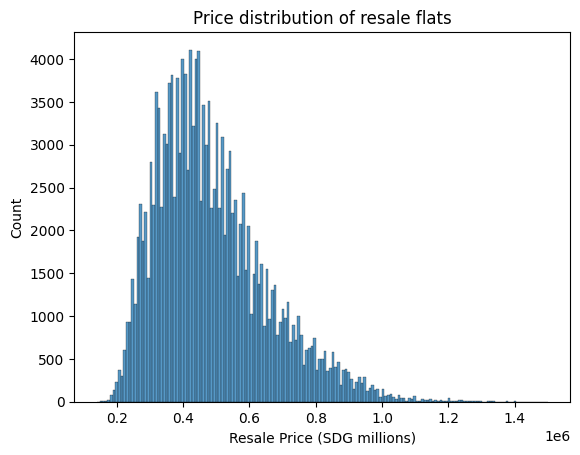

In [ ]:
# Histogram of training set
sns.histplot(data = df_train, x= 'resale_price', stat = 'count')
plt.title('Price distribution of resale flats')
plt.xlabel('Resale Price (SDG millions)')

Distribution of resale prices appears right skewed with mean centred around 0.49 million SGD

month                             2020-03
town                            WOODLANDS
flat_type                          4 ROOM
block                                   8
street_name                  MARSILING DR
storey_range                     01 TO 03
floor_area_sqm                       90.0
flat_model                       Improved
lease_commence_date                  1976
remaining_lease        54 years 10 months
resale_price                     218000.0
Name: 69449, dtype: object
month                             2023-01
town                               YISHUN
flat_type                MULTI-GENERATION
block                                 666
street_name                  YISHUN AVE 4
storey_range                     07 TO 09
floor_area_sqm                      179.0
flat_model               Multi Generation
lease_commence_date                  1987
remaining_lease        63 years 11 months
resale_price                    1080000.0
Name: 145946, dtype: object


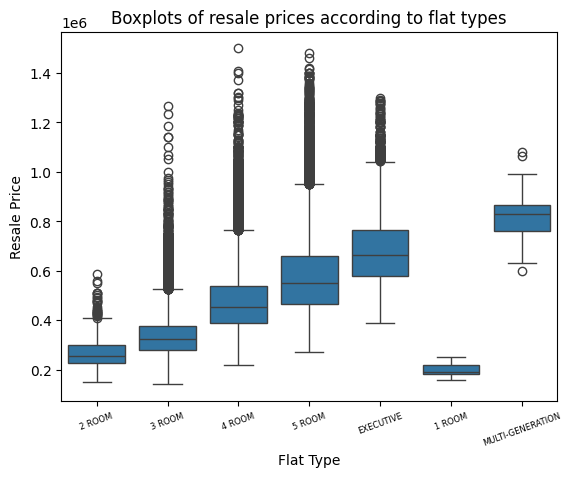

In [ ]:
# Boxplot of training set
sns.boxplot(x = 'flat_type', y = 'resale_price', data = df_train)
plt.xticks(fontsize=6, rotation=20)
plt.title('Boxplots of resale prices according to flat types')
plt.xlabel("Flat Type")
plt.ylabel("Resale Price")

# From boxplot, outlier below IQR in 4-room and outlier above IQR in multi-generation are:
four_rooms = df_train.loc[df['flat_type'] == '4 ROOM']
min_index = four_rooms['resale_price'].idxmin()
four_rooms_outlier = df.iloc[min_index]
print(four_rooms_outlier)

multi_gen = df_train.loc[df['flat_type'] == 'MULTI-GENERATION']
max_index = multi_gen['resale_price'].idxmax()
multi_gen_outlier = df.iloc[max_index]
print(multi_gen_outlier)

From the boxplot, there are 2 potential outliers. One in four room flats and another in multi-generation flats.



<ipython-input-182-cdd5493b7255>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()


<Axes: >

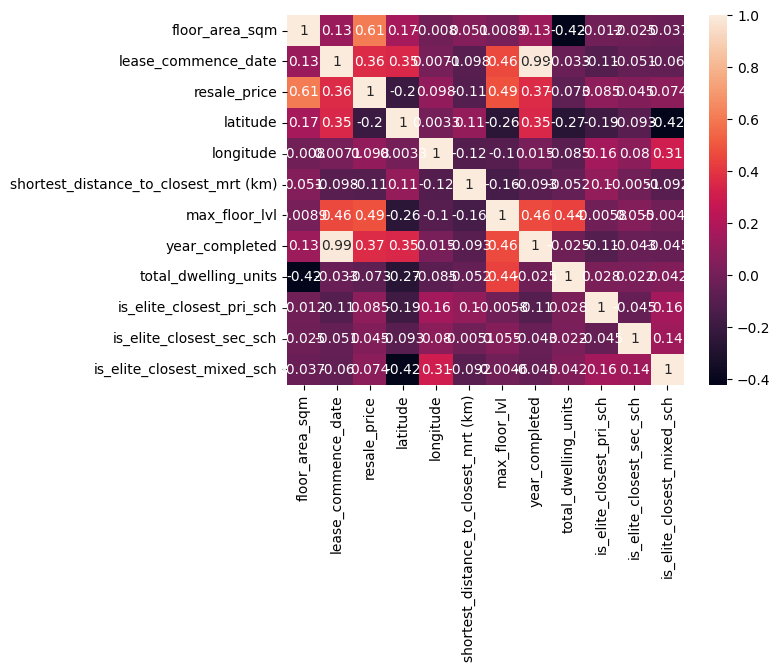

In [ ]:
# Correlation matrix
corr = df_train.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

As expected, year completed is strongly correlated to remaining_lease and should be excluded from model.



(0.0, 89000.0)

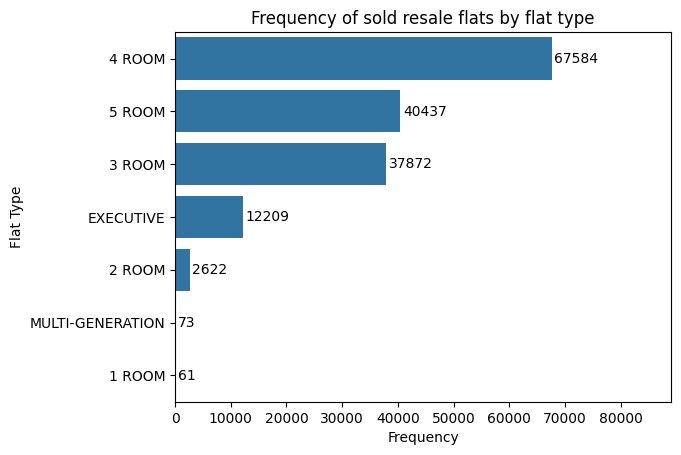

In [ ]:
# Barplot of resale flats by type
freq = df_train['flat_type'].value_counts()
freq_index = freq.index
ax = sns.barplot(y=freq_index, x=freq)
plt.title('Frequency of sold resale flats by flat type')
plt.ylabel('Flat Type')
plt.xlabel('Frequency')
ax.bar_label(ax.containers[0],padding= 2)
ax.set_xlim(0, 89000)

Text(0, 0.5, 'Resale price')

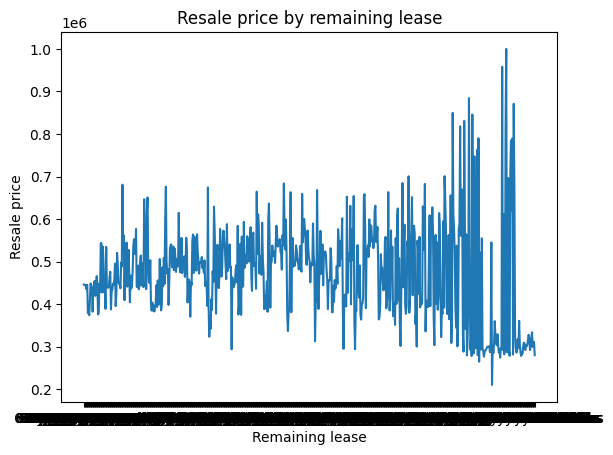

In [ ]:
# Line plot for resale price against remaining lease
sns.lineplot(data=df_train, x='remaining_lease', y='resale_price', errorbar=None)
plt.title('Resale price by remaining lease')
plt.xlabel('Remaining lease')
plt.ylabel('Resale price')

Not surprisingly, resale price is generally higher with increasing remaining lease because longer lease period adds more value to the house because they can be owned for a longer duration.